In [57]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline
from tqdm import tqdm

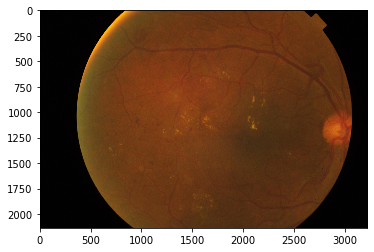

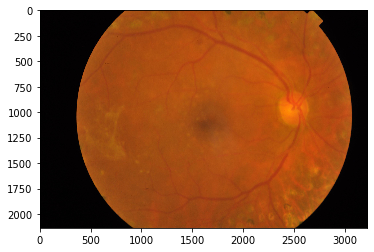

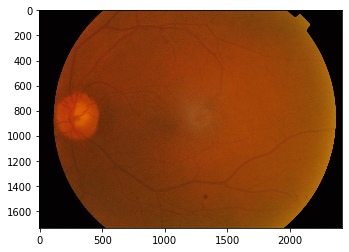

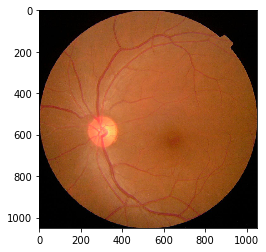

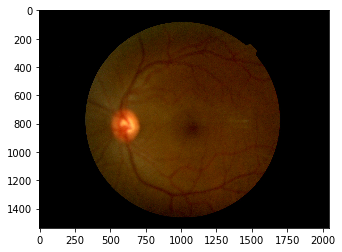

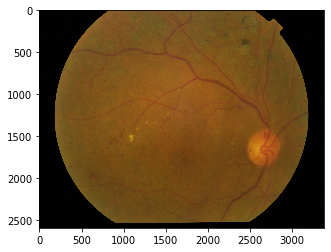

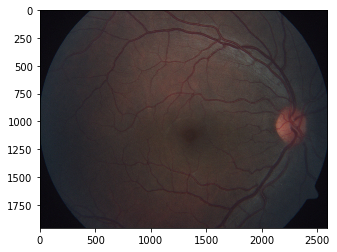

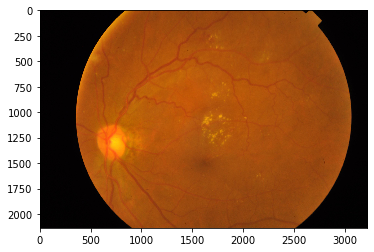

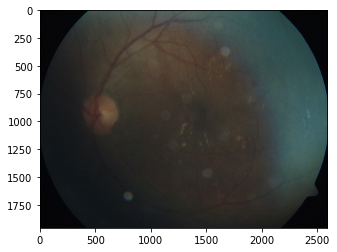

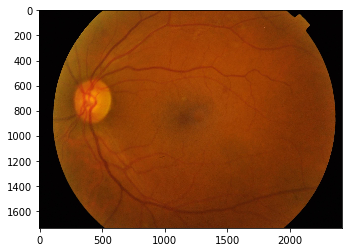

In [58]:
train = pd.read_csv('train.csv')
df = train['id_code']
for i in df[0:10]:
    img = mpimg.imread('./train_images/{0}.png'.format(i))
#     img = cv2.imread('./train_images/{0}.png'.format(i), cv2.IMREAD_UNCHANGED)
    plt.imshow(img)
    plt.show()
#     cv2.imwrite('gray', image)
#     cv2.imshow('gray',image)
#     
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [3]:
df[0:10]

0    000c1434d8d7
1    001639a390f0
2    0024cdab0c1e
3    002c21358ce6
4    005b95c28852
5    0083ee8054ee
6    0097f532ac9f
7    00a8624548a9
8    00b74780d31d
9    00cb6555d108
Name: id_code, dtype: object

In [50]:
class RetinopathyData(Dataset):
    def __init__(self,csv_file,transform):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        img_name = os.path.join('./train_images', self.data.loc[idx,'id_code'] + '.png')
        image = Image.open(img_name)
        image = self.transform(image)
#         image = image.resize((224,224))
        label = torch.tensor(self.data.loc[idx,'diagnosis'])
        return {'image': image,
                'labels': label}
# tensor가 정확하게 뭘까? 왜 train_dataset[3200]은 다 0이나오는걸까

In [51]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [52]:
from torchvision.models import vgg19
VGG19 = torchvision.models.vgg19(pretrained=True)

In [53]:
train_dataset = RetinopathyData(csv_file='train.csv',transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                          shuffle=True, num_workers=2,drop_last=True)
train_dataset[0]

{'image': tensor([[[0.0118, 0.0078, 0.0078,  ..., 0.0078, 0.0118, 0.0118],
          [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0078, 0.0118],
          [0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0078]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0078],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
          [0.0039, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0078],
          [0.0078, 0.0039, 0.00

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG19.to(device)
learning_rate = 0.001
num_epoch = 3
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)

In [56]:
loss_arr = []
# tk0 = tqdm(train_loader, total=int(len(train_loader)))
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,[image,labels] in enumerate(train_loader):
        x = image.to(device, dtype=torch.float)
        y_ = labels.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

BrokenPipeError: [Errno 32] Broken pipe